In [21]:
import scipy
import serial
import time
import csv
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook
import scipy.signal as signal
from scipy.signal import find_peaks
from scipy import fftpack
from scipy.optimize import curve_fit
#from lmfit import Model
from numpy import exp, loadtxt, pi, sqrt

In [131]:
A1 = "20210714-150307_peixe1.csv"
A2 = "20210714-152517_peixe2.csv"
A3_1 = "20210714-155358_peixe3.1.csv"
A3_2 = "20210714-160833_peixe3.2.csv"
A4 = "20210714-162911_peixe4.csv"

data=pd.read_csv(A4)
fish_number = 2
bn = 624
fn = 631

data.columns = ['Tempo','Amplitude', 'Temperatura']

print(data)

begin= int(bn/0.01)- int(10.92/0.01)
finish = int(fn/0.01)- int(10.92/0.01)
# print(finish)

          Tempo  Amplitude  Temperatura
0         10.93       4678        23.58
1         10.94       4681        23.48
2         10.95       4675        23.58
3         10.96       4683        23.48
4         10.97       5015        23.48
...         ...        ...          ...
119150  1203.29       4814        23.38
119151  1203.30       4461        23.28
119152  1203.31       4825        23.38
119153  1203.32       4849        23.38
119154  1203.33       4506        23.38

[119155 rows x 3 columns]


<IPython.core.display.Javascript object>


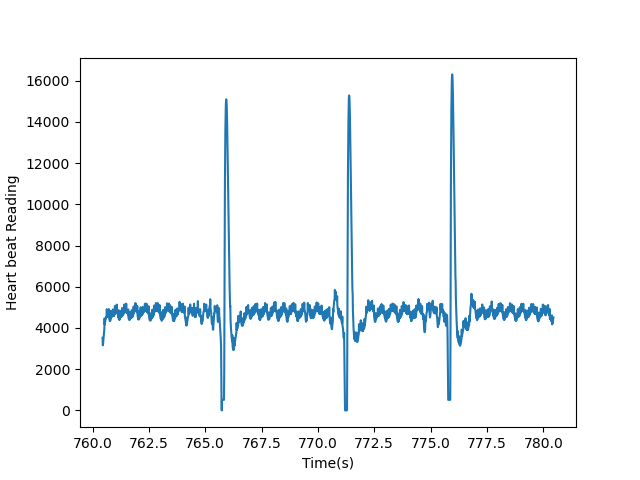

In [36]:
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish])
plt.xlabel('Time(s)')
plt.ylabel('Heart beat Reading')
plt.show()

In [112]:
filename= "peixe{nr}-{i}-{t}-raw.png".format(nr=fish_number, i = bn, t = fn)
plt.savefig(filename)

## Filtering

In [132]:
#Design the Butterworth filter
N  = 2                 # Filter order
Wn = [0.002, 0.08]       # Cutoff frequency
B, A = signal.butter(N, Wn,'bandpass', output='ba')
smooth_data = signal.filtfilt(B,A, data['Amplitude'][begin:finish])

In [124]:
plt.plot(data['Tempo'][begin:finish],data['Amplitude'][begin:finish],'-', color='C0', label='Raw signal', alpha = 1)
plt.plot(data['Tempo'][begin:finish],smooth_data,'k-', alpha = 0.8, label='Filtered signal')
plt.legend(['Raw signal','Filtered signal'], bbox_to_anchor = (0.35, 1))
plt.xlabel('Time (s)')
plt.ylabel('Sensor Reading')
plt.show()

In [143]:
filename= "peixe{nr}-{i}-{t}-filt.png".format(nr=fish_number, i = bn, t = fn)
plt.savefig(filename)

## FFT

In [144]:
D = data['Amplitude'][begin:finish].to_numpy()
Y_raw =abs(np.fft.fft(D))
Y_smooth = abs(np.fft.fft(smooth_data))
Ta = 0.01
Fa=1/Ta
N=data['Tempo'][begin:finish].size
x_fft=np.linspace(0.0,1.0/(2.0*Ta),N//2) #metade da fft
f_raw = 2.0/N * abs(Y_raw[:N//2]) #normalização e só temos metade da fft, porque a fft acaba por ser um espelho 
f_smooth = 2.0/N * abs(Y_smooth[:N//2])
n=len(x_fft)

<IPython.core.display.Javascript object>


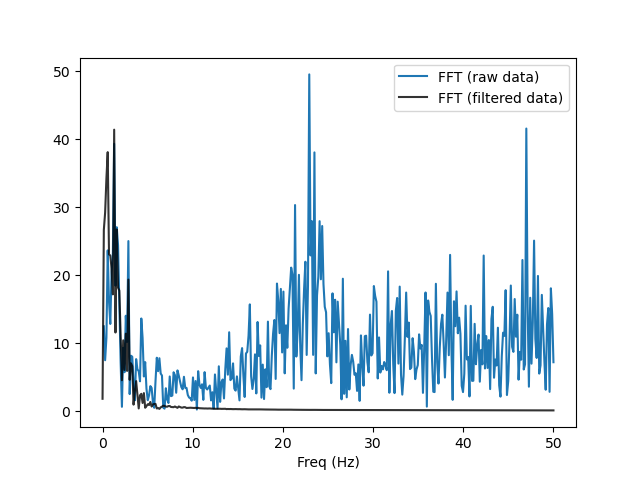

In [145]:
plt.plot(x_fft[1:],f_raw[1:], color='C0', label = 'FFT (raw data)', alpha = 1)
plt.plot(x_fft[:],f_smooth[:],'k', label = 'FFT (filtered data)', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

In [120]:
filename= "peixe{nr}-{i}-{t}-FFT_rawandsmooth_gausss.png".format(nr=fish_number, i = bn, t = fn)
plt.savefig(filename)

## Gaussian Fit

In [146]:
#Gaussian function
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_sum2(x, a, mean, sigma, a1, mean1, sigma1):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2)))

def gaussian_sum3(x, a, mean, sigma, a1, mean1, sigma1, a2, mean2, sigma2):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2))) + (a2*np.exp(-(x-mean2)**2/(2*sigma2**2)))

def gaussian_sum4(x, a, mean, sigma, a1, mean1, sigma1, a2, mean2, sigma2, a3, mean3, sigma3):
    return (a*np.exp(-(x-mean)**2/(2*sigma**2))) + (a1*np.exp(-(x-mean1)**2/(2*sigma1**2))) + (a2*np.exp(-(x-mean2)**2/(2*sigma2**2))) + (a3*np.exp(-(x-mean3)**2/(2*sigma3**2)))

#mean=sum(x_fft*f)/n
#sigma=sum(f*(x_fft-mean)**2)/n

In [150]:
best_vals, cov_vals = curve_fit(f=gaussian, xdata=x_fft[2:], ydata = f_smooth[2:], p0=[20, 1,0.5]) #best_vals = melhores valores para a, mean e sigma
# best_vals, cov_vals = curve_fit(f=gaussian, xdata=x_fft, ydata = f_smooth, p0=[1,1,0.5])
print(best_vals)

[40.47365568 -1.11339457  2.16888153]


Gaussiana 1: -1.1133945716826366


<IPython.core.display.Javascript object>


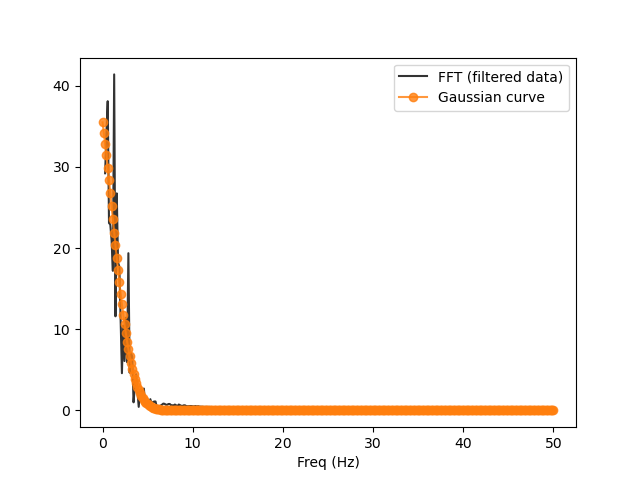

In [151]:
y_fft1 = gaussian(x_fft,best_vals[0],best_vals[1],best_vals[2])
print("Gaussiana 1: {}".format(best_vals[1]))
# y_fft2 = gaussian(x_fft,best_vals[3],best_vals[4],best_vals[5])
# print("Gaussiana 2: {}".format(best_vals[4]))
# y_fft3 = gaussian(x_fft,best_vals[6],best_vals[7],best_vals[8])
# print("Gaussiana 3: {}".format(best_vals[7]))

plt.plot(x_fft[2:],f_smooth[2:],'k',label='FFT (filtered data)',  alpha = 0.8)
plt.plot(x_fft,gaussian(x_fft, *best_vals),'o-',color = 'C1',label='Gaussian curve', alpha = 0.8)
plt.legend(loc='best')
plt.xlabel('Freq (Hz)')
plt.show()

In [119]:
filename= "peixe{nr}-{i}-{t}-sum_gauss.png".format(nr=fish_number, i = bn, t = fn)
plt.savefig(filename)

<IPython.core.display.Javascript object>


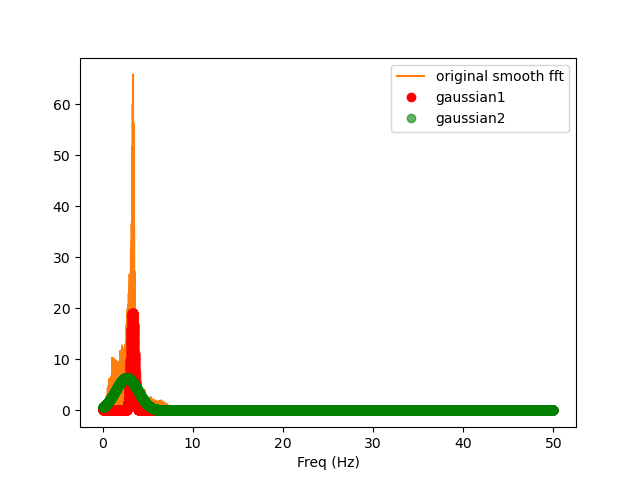

In [298]:
# plt.plot(x_fft[1:],f_smooth[1:],'tab:orange',label='original smooth fft')
# plt.plot(x_fft, y_fft1, 'ro', label = 'gaussian1')
# plt.plot(x_fft, y_fft2, 'go', label = 'gaussian2', alpha = 0.6)
# # plt.plot(x_fft, y_fft3, 'bo', label = 'gaussian3',alpha = 0.6)
# plt.legend(loc='best')
# plt.xlabel('Freq (Hz)')
# plt.show()

In [427]:
# plt.savefig('peixe5-290-326-gaussians.png')

In [93]:
# summ = gaussian_sum2(x_fft, best_vals[3], best_vals[4], best_vals[5], best_vals[6], best_vals[7],  best_vals[8])
# plt.plot(x_fft[1:],f_smooth[1:],'b+:',label='original smooth fft')
# plt.plot(x_fft, summ , 'ro', label = 'gaussian_sum')
# plt.legend(loc='best')
# plt.xlabel('Freq (Hz)')
# plt.show()

In [88]:
# plt.savefig('peixe2-342-380-gaussians2.png')

### Pwelch

<IPython.core.display.Javascript object>


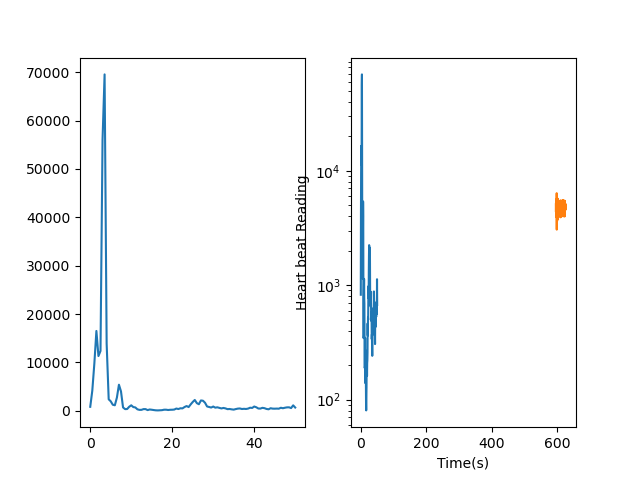

7
3.5
[0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.5, 9.0, 9.5, 10.0, 10.5, 11.0, 11.5, 12.0, 12.5, 13.0, 13.5, 14.0, 14.5, 15.0, 15.5, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0, 30.5, 31.0, 31.5, 32.0, 32.5, 33.0, 33.5, 34.0, 34.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0]


In [25]:
f1, Pxx_den = signal.welch(D,100, nperseg=200, noverlap = 10)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(f1, Pxx_den)
ax2.semilogy(f1, Pxx_den)
plt.xlabel('frequency [Hz]')
# plt.ylabel('PSD [V**2/Hz]')
plt.show()

f11 = list(f1)
p = list(Pxx_den)
m = max(Pxx_den)
print(p.index(m))
print(f11[p.index(m)])
print(f11)

In [26]:
filename= "peixe{nr}-{i}-{t}-welch_raw.png".format(nr=fish_number, i = bn, t = fn)
# print(filename)
plt.savefig(filename)

## Find_peaks

In [133]:
smooth_data = smooth_data/max(smooth_data)
peaks_op, _ = find_peaks(smooth_data, height =1.1, distance = 35, threshold = 0.0000000001) #retorna os indices dos picos 
# print(peaks_op)
peaks_all, _ = find_peaks(smooth_data, height =-0, distance = 35, threshold = 0.00001)
peak = peaks_all.tolist()

d = len(peak)-len(peaks_op)
# print(d)
# print(peak)
# print(peaks_op)
for n in range(len(peaks_op)):
#     print("operculum peaks {}". format(n))
    for m in range(d): # não percebo porque é que às vezes é só d e outras é d+1???
#         print("difference peaks {}". format(m))
        if peaks_op[n] == peak[m]:
            peak.remove(peak[m])

print(len(peak))            
print("\nheart_peaks {}\n".format(peak))
print("operculum peaks {}". format(peaks_op))

plt.plot(smooth_data)
plt.plot(peak, smooth_data[peak], "x")
# plt.plot(np.zeros_like(smooth_data), "--", color="gray")
plt.show()

10

heart_peaks [18, 87, 153, 230, 298, 368, 474, 542, 607, 655]

operculum peaks []


In [134]:
heart_beat = []

for n in range(len(peak)-1):
    delta_t = data['Tempo'][peak[n+1]]-data['Tempo'][peak[n]]
    if delta_t < 10:
        f_min = 60/delta_t
        heart_beat.append(f_min)
        
    else:
        print("error")
        
#hb = np.around(heart_beat, 2)
#print(len(hb))

print(heart_beat)
print(round(np.mean(heart_beat),1))

[86.95652173913027, 90.90909090909089, 77.92207792207796, 88.2352941176471, 85.71428571428581, 56.60377358490563, 88.23529411764686, 92.3076923076925, 124.99999999999989]
88.0


In [102]:
heart_beat = []

for n in range(len(peak)-1):
    delta_t = data['Tempo'][peak[n+1]]-data['Tempo'][peak[n]]
    heart_beat.append(delta_t)
print(heart_beat)

[0.33999999999999986, 0.5100000000000016, 0.4399999999999977, 0.3000000000000007, 0.3099999999999987, 0.2900000000000027, 0.35999999999999943, 0.5199999999999996, 0.6899999999999977]


In [11]:
#tempos dos picos
t = list(data['Tempo'][begin:finish])
td = []
for m in range(len(peak)):
    u = peak[m]
    td.append(t[u])
print(td)

[624.49, 625.18, 625.84, 626.61, 627.29, 627.99, 629.05, 629.73, 630.38, 630.86]


### Remove heart rate values outside 2 desvio padrão

In [152]:
up = 88 + 2*20
down = 88 - 2*20
# length = len(heart_beat)-1
# for element in heart_beat:
#     if element > up:
#         heart_beat.remove(element)
#     if element < down:
#         heart_beat.remove(element)
# print(len(heart_beat))
# print(heart_beat)
# # print(down)
# print(round(np.mean(heart_beat),1))

h= []
for n in range(len(heart_beat)-1):
    if down < heart_beat[n] < up:
        h.append(heart_beat[n])
#     if heart_beat[n] > down:
#          h.append(heart_beat[n])    
print(h)
print(round(np.mean(h),1))

[86.95652173913027, 90.90909090909089, 77.92207792207796, 88.2352941176471, 85.71428571428581, 56.60377358490563, 88.23529411764686, 92.3076923076925]
83.4


# Calculo do erro dos sensores

87.98711449027522
17.641319177023064
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 0 1 0 0 2 0 0 0 0 0 0 0 1 0 0 1]
[56.60377358 56.96081277 57.31785196 57.67489115 58.03193033 58.38896952
 58.74600871 59.1030479  59.46008708 59.81712627 60.17416546 60.53120464
 60.88824383 61.24528302 61.60232221 61.95936139 62.31640058 62.67343977
 63.03047896 63.38751814 63.74455733 64.10159652 64.4586357  64.81567489
 65.17271408 65.52975327 65.88679245 66.24383164 66.60087083 66.95791001
 67.3149492  67.67198839 68.02902758 68.38606676 68.74310595 69.10014514
 69.45718433 69.81422351 70.1712627  70.52830189 70.88534107 71.24238026
 71.59941945 71.95645864 72.31349782 72.67053701 73.0275762  73.38461538
 73.74165457 74.09869376 74.45573295 74.81277213 75.16981132 75.52685051
 75.8838897  76.24092888 76.59796807 76.95500726 77.31204644 77.66908563
 78.02612482 78.38316401 78.7

<IPython.core.display.Javascript object>


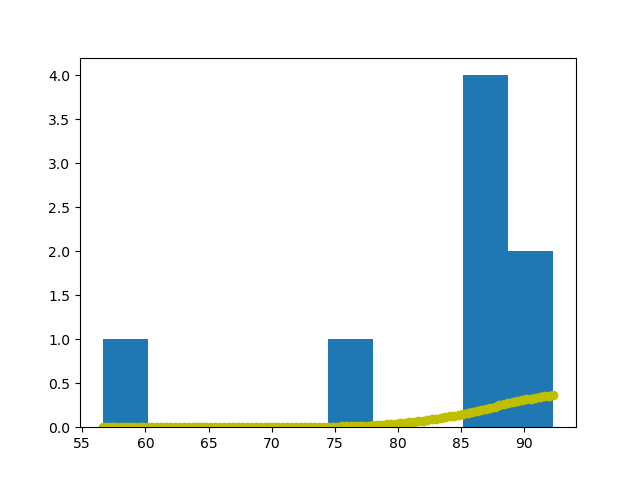

(array([1., 0., 0., 0., 0., 1., 0., 0., 4., 2.]),
 array([56.60377358, 60.17416546, 63.74455733, 67.3149492 , 70.88534107,
        74.45573295, 78.02612482, 81.59651669, 85.16690856, 88.73730044,
        92.30769231]),
 <BarContainer object of 10 artists>)

In [153]:
from scipy.stats import norm
import statistics
mean = statistics.mean(heart_beat)
sd = statistics.stdev(heart_beat)
print(mean)
print(sd)
from scipy.optimize import curve_fit
def gaussian(x, a, mean, sigma):
    return a*np.exp(-(x-mean)**2/(2*sigma**2))

hist, bin_edges = np.histogram(h, bins = 100)
print(hist)
print(bin_edges)
best_vals, cov_vals = curve_fit(f=gaussian, xdata=bin_edges[:-1],ydata=hist, p0=[1, mean, 2])


print("Gaussiana 1: {}".format(best_vals))
plt.plot(bin_edges,gaussian(bin_edges, *best_vals),'yo',label='gaussian_sum')
# plt.plot( bin_edges[:-1], hist, 'o')
plt.hist(h)